In [12]:
import numpy as np

def monte_carlo_dop_stable(S0, K, T, r, v0, alpha, beta, gamma, rho, barrier_func, n_simulations=100000, n_steps=252):
    """
    Prices a Down-and-Out Put option using a stable Monte Carlo simulation.

    This function simulates the price path of an underlying asset using a 2-factor model
    by simulating the log-price for numerical stability. It uses the "full truncation"
    method for the volatility process.

    Args:
        S0 (float): Initial stock price.
        K (float): Strike price of the option.
        T (float): Time to maturity of the option in years.
        r (float): Risk-free interest rate.
        v0 (float): Initial variance.
        alpha (float): Parameter for variance process.
        beta (float): Parameter for variance process.
        gamma (float): Volatility of variance.
        rho (float): Correlation between the two Brownian motions.
        barrier_func (function): A function that takes time t and returns the barrier level.
        n_simulations (int, optional): The number of Monte Carlo simulations. Defaults to 100000.
        n_steps (int, optional): The number of time steps in each simulation. Defaults to 252.

    Returns:
        float: The estimated price of the Down-and-Out Put option.
    """
    dt = T / n_steps
    # Initialize log-price and variance arrays
    log_S = np.full(n_simulations, np.log(S0))
    v = np.full(n_simulations, v0)

    # Keep track of which paths are active
    active_paths = np.full(n_simulations, True)

    for i in range(1, n_steps + 1):
        t = i * dt
        v_plus = np.maximum(v, 0)

        # Scale random numbers by sqrt(dt)
        sqrt_dt = np.sqrt(dt)
        Z1 = np.random.normal(size=n_simulations)
        Z2 = np.random.normal(size=n_simulations)
        dW = sqrt_dt * Z1
        dB = sqrt_dt * (rho * Z1 + np.sqrt(1 - rho**2) * Z2)

        # Update log stock price and variance only for active paths
        # This is an optimization; we don't need to compute for paths already knocked out
        active_v_plus = v_plus[active_paths]

        log_S[active_paths] += (r - 0.5 * active_v_plus) * dt + np.sqrt(active_v_plus) * dW[active_paths]
        v[active_paths] += (alpha + beta * active_v_plus) * dt + gamma * np.sqrt(active_v_plus) * dB[active_paths]

        # Check for barrier breach
        current_S = np.exp(log_S)
        barrier = barrier_func(t)

        # Identify paths that are active and have breached the barrier in this step
        knocked_out_this_step = (current_S <= barrier) & active_paths
        active_paths[knocked_out_this_step] = False

    # Calculate final payoff only for paths that were never knocked out
    final_S = np.exp(log_S)
    payoff = np.maximum(K - final_S, 0)
    payoff[~active_paths] = 0  # Set payoff to 0 for all knocked-out paths

    option_price = np.exp(-r * T) * np.mean(payoff)

    return option_price

# Default parameter values
v0 = 0.1
alpha = 0.45
beta = -5.105
gamma = 0.25
S0 = 100.0
r = 0.05
rho = -0.75
K = 100.0
T = 1

# Barrier functions
def barrier_s1(t):
    return 94.0

def barrier_s2(t):
    return 6 * t + 91.0

def barrier_s3(t):
    return -6 * t + 97.0

# Estimate the prices using the STABLE function
P1 = monte_carlo_dop_stable(S0, K, T, r, v0, alpha, beta, gamma, rho, barrier_s1, n_steps=10000)
P2 = monte_carlo_dop_stable(S0, K, T, r, v0, alpha, beta, gamma, rho, barrier_s2, n_steps=10000)
P3 = monte_carlo_dop_stable(S0, K, T, r, v0, alpha, beta, gamma, rho, barrier_s3, n_steps=10000)

print(f"Price (P1) of the Down-and-Out Put option with a constant barrier at $94: ${P1:.4f}")
print(f"Price (P2) of the Down-and-Out Put option with a time-dependent barrier Sb2(t) = 6t + 91: ${P2:.4f}")
print(f"Price (P3) of the Down-and-Out Put option with a time-dependent barrier Sb3(t) = -6t + 97: ${P3:.4f}")

Price (P1) of the Down-and-Out Put option with a constant barrier at $94: $0.0064
Price (P2) of the Down-and-Out Put option with a time-dependent barrier Sb2(t) = 6t + 91: $0.0011
Price (P3) of the Down-and-Out Put option with a time-dependent barrier Sb3(t) = -6t + 97: $0.0107


In [15]:
import numpy as np

def price_coupon_bond_CIR(
    r0=0.05,
    kappa=0.92,
    r_bar=0.055,
    sigma=0.12,
    face_value=1000,
    coupon=30,
    T=4,
    num_paths=100000,
    num_steps=1000,
    seed=42
):
    """
    Monte Carlo pricing of a semiannual coupon bond under the CIR short rate model.

    Parameters
    ----------
    r0 : float
        Initial short rate.
    kappa : float
        Mean reversion speed.
    r_bar : float
        Long-term mean rate.
    sigma : float
        Volatility of short rate.
    face_value : float
        Face value of the bond.
    coupon : float
        Semiannual coupon amount.
    T : float
        Maturity in years.
    num_paths : int
        Number of Monte Carlo paths.
    num_steps : int
        Time steps per path.
    seed : int
        Random seed.

    Returns
    -------
    bond_price : float
        Monte Carlo estimate of the bond price.
    """
    np.random.seed(seed)
    dt = T / num_steps
    times = np.linspace(0, T, num_steps + 1)
    r = np.full((num_paths, num_steps + 1), r0)

    for t in range(num_steps):
        z = np.random.normal(size=num_paths)
        sqrt_r = np.sqrt(np.maximum(r[:, t], 0))
        dr = kappa * (r_bar - r[:, t]) * dt + sigma * sqrt_r * np.sqrt(dt) * z
        r[:, t + 1] = np.maximum(r[:, t] + dr, 0)

    int_r_dt = np.cumsum(r[:, :-1] * dt, axis=1)

    cashflow_times = np.array([0.5 * (i + 1) for i in range(8)])
    cashflows = np.full(8, coupon)
    cashflows[-1] += face_value

    step_indices = (cashflow_times / dt).astype(int)
    discounts = np.exp(-int_r_dt[:, step_indices - 1])

    pv_paths = discounts @ cashflows
    bond_price = np.mean(pv_paths)

    return bond_price


In [16]:
price = price_coupon_bond_CIR()
print(f"Bond Price: ${price:.2f}")


Bond Price: $1021.45


Option Price: $0.39


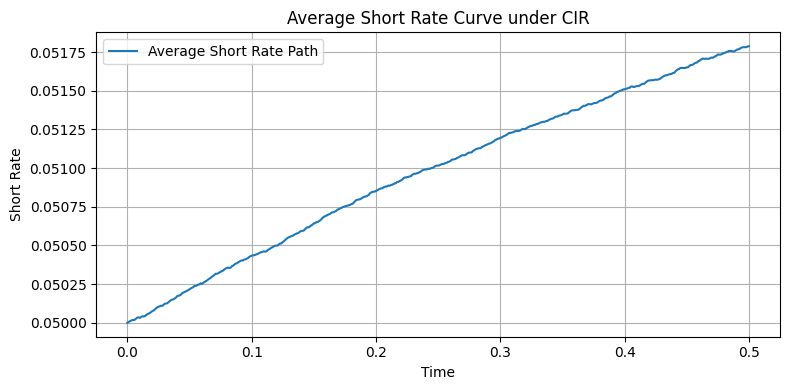

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def cir_bond_price_A_B(kappa, r_bar, sigma, T, S):
    h = np.sqrt(kappa**2 + 2 * sigma**2)
    exp_ht = np.exp(h * (S - T))
    numerator = 2 * h * np.exp((kappa + h) * (S - T) / 2)
    denominator = 2 * h + (kappa + h) * (exp_ht - 1)
    B = 2 * (exp_ht - 1) / denominator
    A = (numerator / denominator) ** (2 * kappa * r_bar / sigma**2)
    return A, B

def price_bond_option_CIR_call(
    r0=0.05, kappa=0.92, r_bar=0.055, sigma=0.12,
    T=0.5, S=1.0, K=980, face_value=1000,
    num_paths=100000, num_steps=500, seed=42
):
    np.random.seed(seed)
    dt = T / num_steps
    r = np.full((num_paths, num_steps + 1), r0)

    for t in range(num_steps):
        z = np.random.normal(size=num_paths)
        sqrt_r = np.sqrt(np.maximum(r[:, t], 0))
        dr = kappa * (r_bar - r[:, t]) * dt + sigma * sqrt_r * np.sqrt(dt) * z
        r[:, t + 1] = np.maximum(r[:, t] + dr, 0)

    int_r_dt = np.sum(r[:, :-1] * dt, axis=1)
    r_T = r[:, -1]

    A, B = cir_bond_price_A_B(kappa, r_bar, sigma, T, S)
    P_T_S = face_value * A * np.exp(-B * r_T)
    payoff = np.maximum(P_T_S - K, 0)
    discounted_payoff = np.exp(-int_r_dt) * payoff
    option_price = np.mean(discounted_payoff)

    avg_rate_path = np.mean(r, axis=0)
    time_grid = np.linspace(0, T, num_steps + 1)
    return option_price, time_grid, avg_rate_path

# Run and plot
option_price, time_grid, avg_rates = price_bond_option_CIR_call()
print(f"Option Price: ${option_price:.2f}")

plt.figure(figsize=(8, 4))
plt.plot(time_grid, avg_rates, label="Average Short Rate Path")
plt.xlabel("Time")
plt.ylabel("Short Rate")
plt.title("Average Short Rate Curve under CIR")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def cir_zcb_price(r, kappa, r_bar, sigma, T, S, face_value=1000):
    h = np.sqrt(kappa**2 + 2 * sigma**2)
    exp_h_delta = np.exp(h * (S - T))
    numerator = 2 * h * np.exp((kappa + h) * (S - T) / 2)
    denominator = 2 * h + (kappa + h) * (exp_h_delta - 1)
    B = 2 * (exp_h_delta - 1) / denominator
    A = (numerator / denominator) ** (2 * kappa * r_bar / sigma**2)
    return face_value * A * np.exp(-B * r)

def pde_bond_option_CIR(
    r0=0.05, kappa=0.92, r_bar=0.055, sigma=0.12,
    T=0.5, S=1.0, K=980, face_value=1000,
    r_max=0.2, M=400, N=500
):
    """
    Implicit FDM solver for a European call option on a ZCB under CIR model.
    """
    dr = r_max / M
    dt = T / N
    r_grid = np.linspace(0, r_max, M + 1)

    # Terminal condition: max(P(T,S) - K, 0)
    P_T_S = cir_zcb_price(r_grid, kappa, r_bar, sigma, T, S, face_value)
    V = np.maximum(P_T_S - K, 0)

    # Backward time stepping
    for n in reversed(range(N)):
        A = np.zeros((M - 1, M - 1))
        b = np.zeros(M - 1)
        for i in range(1, M):
            ri = r_grid[i]
            a = 0.5 * dt * (sigma**2 * ri / dr**2 - kappa * (r_bar - ri) / (2 * dr))
            b_mid = 1 + dt * (sigma**2 * ri / dr**2 + ri)
            c = 0.5 * dt * (sigma**2 * ri / dr**2 + kappa * (r_bar - ri) / (2 * dr))

            if i > 1:
                A[i - 1, i - 2] = -a
            A[i - 1, i - 1] = b_mid
            if i < M - 1:
                A[i - 1, i] = -c
            b[i - 1] = V[i]

        V[1:M] = np.linalg.solve(A, b)
        V[0] = V[1]  # Neumann BC at r=0
        V[M] = 0     # Dirichlet BC at r=r_max

    # Interpolate the price at r0
    return np.interp(r0, r_grid, V)


In [1]:
import numpy as np

def cir_zcb_price(r, kappa, r_bar, sigma, T, S, face_value=1000):
    h = np.sqrt(kappa**2 + 2 * sigma**2)
    exp_h_delta = np.exp(h * (S - T))
    numerator = 2 * h * np.exp((kappa + h) * (S - T) / 2)
    denominator = 2 * h + (kappa + h) * (exp_h_delta - 1)
    B = 2 * (exp_h_delta - 1) / denominator
    A = (numerator / denominator) ** (2 * kappa * r_bar / sigma**2)
    return face_value * A * np.exp(-B * r)

def pde_bond_option_CIR(
    r0=0.05, kappa=0.92, r_bar=0.055, sigma=0.12,
    T=0.5, S=1.0, K=980, face_value=1000,
    r_max=0.2, M=400, N=500
):
    """
    Implicit FDM solver for a European call option on a ZCB under CIR model.
    """
    dr = r_max / M
    dt = T / N
    r_grid = np.linspace(0, r_max, M + 1)

    # Terminal condition: max(P(T,S) - K, 0)
    P_T_S = cir_zcb_price(r_grid, kappa, r_bar, sigma, T, S, face_value)
    V = np.maximum(P_T_S - K, 0)

    # Backward time stepping
    for n in reversed(range(N)):
        A = np.zeros((M - 1, M - 1))
        b = np.zeros(M - 1)
        for i in range(1, M):
            ri = r_grid[i]
            a = 0.5 * dt * (sigma**2 * ri / dr**2 - kappa * (r_bar - ri) / (2 * dr))
            b_mid = 1 + dt * (sigma**2 * ri / dr**2 + ri)
            c = 0.5 * dt * (sigma**2 * ri / dr**2 + kappa * (r_bar - ri) / (2 * dr))

            if i > 1:
                A[i - 1, i - 2] = -a
            A[i - 1, i - 1] = b_mid
            if i < M - 1:
                A[i - 1, i] = -c
            b[i - 1] = V[i]

        V[1:M] = np.linalg.solve(A, b)
        V[0] = V[1]  # Neumann BC at r=0
        V[M] = 0     # Dirichlet BC at r=r_max

    # Interpolate the price at r0
    return np.interp(r0, r_grid, V)


In [2]:
option_price_pde = pde_bond_option_CIR()
print(f"Call Option Price (PDE): ${option_price_pde:.4f}")


Call Option Price (PDE): $0.5936


In [3]:
import numpy as np

def g2pp_put_price_mc(
    T=0.5, S=1.0, K=950, rho=0.7,
    a=0.1, b=0.3, sigma=0.05, eta=0.09,
    phi=0.055, x0=0.0, y0=0.0,
    n_paths=10000, n_steps=500, seed=42
):
    np.random.seed(seed)
    dt = T / n_steps
    x = np.full(n_paths, x0)
    y = np.full(n_paths, y0)
    sqrt_dt = np.sqrt(dt)

    for _ in range(n_steps):
        Z1 = np.random.normal(size=n_paths)
        Z2 = np.random.normal(size=n_paths)
        dW1 = sqrt_dt * Z1
        dW2 = sqrt_dt * (rho * Z1 + np.sqrt(max(0, 1 - rho**2)) * Z2)
        x += -a * x * dt + sigma * dW1
        y += -b * y * dt + eta * dW2

    tau = S - T
    Bx = (1 - np.exp(-a * tau)) / a
    By = (1 - np.exp(-b * tau)) / b

    sigma_p_sq = (sigma**2) * Bx**2 * (1 - np.exp(-2 * a * T)) / (2 * a) + \
                 (eta**2) * By**2 * (1 - np.exp(-2 * b * T)) / (2 * b) + \
                 2 * rho * sigma * eta * Bx * By * (1 - np.exp(-(a + b) * T)) / (a + b)

    A = np.exp(phi * tau - 0.5 * sigma_p_sq)
    P_T_S = 1000 * A * np.exp(-Bx * x - By * y)

    payoff = np.maximum(K - P_T_S, 0)
    r_avg = x + y + phi
    disc_factor = np.exp(-r_avg * T)
    return np.mean(disc_factor * payoff)


In [4]:
output_1 = g2pp_put_price_mc()
print(f"Put Option Price (ρ = 0.7): ${output_1:.4f}")


Put Option Price (ρ = 0.7): $0.3753


In [5]:
import pandas as pd

rhos = np.round(np.arange(-0.7, 0.71, 0.1), 2)
prices = [g2pp_put_price_mc(rho=r) for r in rhos]

rho_price_df = pd.DataFrame({'ρ': rhos, 'Put Option Price': prices})
print(rho_price_df)


      ρ  Put Option Price
0  -0.7          0.000146
1  -0.6          0.001819
2  -0.5          0.005973
3  -0.4          0.012211
4  -0.3          0.020160
5  -0.2          0.031818
6  -0.1          0.049330
7  -0.0          0.070798
8   0.1          0.096937
9   0.2          0.127456
10  0.3          0.162508
11  0.4          0.203947
12  0.5          0.254486
13  0.6          0.312947
14  0.7          0.375338


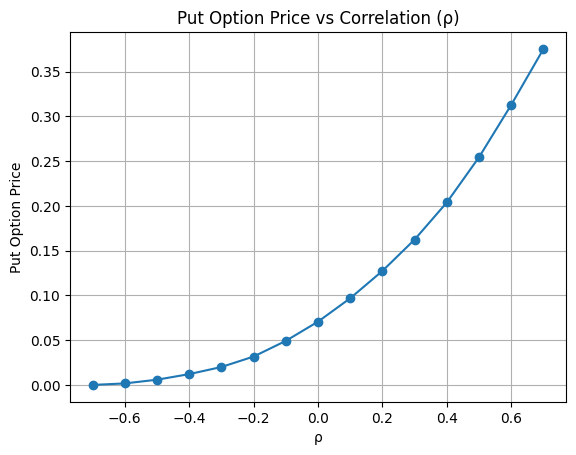

In [6]:
import matplotlib.pyplot as plt

plt.plot(rho_price_df['ρ'], rho_price_df['Put Option Price'], marker='o')
plt.title('Put Option Price vs Correlation (ρ)')
plt.xlabel('ρ')
plt.ylabel('Put Option Price')
plt.grid(True)
plt.show()


In [7]:
import numpy as np

def simulate_CIR_paths(r0, kappa, r_bar, sigma, T, dt, n_paths, seed=42):
    """
    Simulate CIR interest rate paths.

    Parameters:
        r0: initial rate
        kappa: mean reversion speed
        r_bar: long-run mean
        sigma: volatility
        T: time in years
        dt: time step (e.g., 1/12 for monthly)
        n_paths: number of simulation paths
        seed: random seed

    Returns:
        A numpy array of shape (n_paths, n_steps+1) with simulated rates.
    """
    np.random.seed(seed)
    n_steps = int(T / dt)
    rates = np.zeros((n_paths, n_steps + 1))
    rates[:, 0] = r0

    for t in range(1, n_steps + 1):
        rt = rates[:, t - 1]
        dWt = np.random.normal(0.0, np.sqrt(dt), size=n_paths)
        dr = kappa * (r_bar - rt) * dt + sigma * np.sqrt(np.maximum(rt, 0)) * dWt
        rates[:, t] = rt + dr

    return rates


def numerix_prepayment_model(rates, WAC, months, notional):
    """
    Generate cashflows using Numerix-style prepayment logic.

    Parameters:
        rates: CIR paths (n_paths, n_steps)
        WAC: Weighted Average Coupon (annual)
        months: number of payment periods (e.g., 360 for 30 years)
        notional: total loan principal

    Returns:
        cashflows, principal, interest arrays (n_paths, months)
    """
    n_paths, _ = rates.shape
    dt = 1 / 12
    r_monthly = rates[:, :months]

    # Base CPR based on refinancing incentive
    base_CPR = 0.06 + 0.1 * np.maximum(WAC - r_monthly, 0)

    # Constant burnout factor
    burnout = 0.8
    CPR = burnout * base_CPR
    SMM = 1 - np.power(1 - CPR, 1 / 12)

    remaining_balance = np.full((n_paths, months), notional)
    cashflows = np.zeros((n_paths, months))
    principal = np.zeros_like(cashflows)
    interest = np.zeros_like(cashflows)
    mortgage_rate = WAC / 12

    for t in range(months):
        if t > 0:
            remaining_balance[:, t] = remaining_balance[:, t - 1] - principal[:, t - 1]
        interest[:, t] = remaining_balance[:, t] * mortgage_rate
        scheduled_principal = np.full(n_paths, notional / months)
        prepaid_principal = (remaining_balance[:, t] - scheduled_principal) * SMM[:, t]
        principal[:, t] = np.minimum(scheduled_principal + prepaid_principal, remaining_balance[:, t])
        cashflows[:, t] = interest[:, t] + principal[:, t]

    return cashflows, principal, interest


def price_MBS(CIR_paths, cashflows, dt=1/12):
    """
    Price the MBS using discounted expected cashflows.

    Parameters:
        CIR_paths: short rate simulations
        cashflows: cashflow matrix
        dt: time step in years

    Returns:
        Present value (price) of the MBS
    """
    discount_factors = np.exp(-np.cumsum(CIR_paths[:, :cashflows.shape[1]], axis=1) * dt)
    pv_paths = np.sum(cashflows * discount_factors, axis=1)
    return np.mean(pv_paths)


In [8]:
# Simulate 10,000 CIR paths
cir_paths = simulate_CIR_paths(r0=0.078, kappa=0.6, r_bar=0.08, sigma=0.12, T=30, dt=1/12, n_paths=10000)

# Generate MBS cashflows using Numerix model
cashflows, principal, interest = numerix_prepayment_model(cir_paths, WAC=0.08, months=360, notional=100000)

# Price the MBS
mbs_price = price_MBS(cir_paths, cashflows)


In [9]:
print(mbs_price)

100640.98801796536


In [10]:
from scipy.optimize import brentq
import numpy as np

def price_MBS_with_spread(CIR_paths, cashflows, spread_bps=0, dt=1/12):
    """
    Price MBS with a constant spread (in basis points) added to discount rate.

    Parameters:
        CIR_paths: simulated short rate paths
        cashflows: cashflows (n_paths, n_months)
        spread_bps: constant spread to add (in basis points)
        dt: time increment (1/12 for monthly)

    Returns:
        Spread-adjusted present value
    """
    spread = spread_bps / 10000  # Convert bps to decimal
    discount_factors = np.exp(-np.cumsum(CIR_paths[:, :cashflows.shape[1]] + spread, axis=1) * dt)
    pv_paths = np.sum(cashflows * discount_factors, axis=1)
    return np.mean(pv_paths)


def compute_OAS(CIR_paths, cashflows, market_price, dt=1/12):
    """
    Compute Option-Adjusted Spread (OAS) via root-finding.

    Parameters:
        CIR_paths: simulated CIR paths
        cashflows: cashflows from Numerix model
        market_price: observed market price (e.g. 98000)
        dt: time increment

    Returns:
        OAS in basis points
    """

    def objective(spread_bps):
        return price_MBS_with_spread(CIR_paths, cashflows, spread_bps, dt) - market_price

    oas_bps = brentq(objective, -1000, 1000)  # search range: [-1000, 1000] bps
    return oas_bps


In [11]:
# Step 1: simulate CIR paths
cir_paths = simulate_CIR_paths(0.078, 0.6, 0.08, 0.12, 30, 1/12, 10000)

# Step 2: generate cashflows from Numerix model
cashflows, _, _ = numerix_prepayment_model(cir_paths, WAC=0.08, months=360, notional=100000)

# Step 3: compute OAS given market price
oas = compute_OAS(cir_paths, cashflows, market_price=98000)
print(f"Option-Adjusted Spread (OAS): {oas:.2f} bps")


Option-Adjusted Spread (OAS): 50.68 bps


In [12]:
def price_io_po_tranches(CIR_paths, principal, interest, dt=1/12):
    """
    Compute IO (interest-only) and PO (principal-only) tranche prices.

    Parameters:
        CIR_paths: simulated CIR short rate paths (n_paths x n_steps)
        principal: principal cashflows matrix (n_paths x months)
        interest: interest cashflows matrix (n_paths x months)
        dt: time increment (monthly = 1/12)

    Returns:
        Tuple (IO_price, PO_price)
    """
    discount_factors = np.exp(-np.cumsum(CIR_paths[:, :principal.shape[1]], axis=1) * dt)
    io_pv = np.sum(interest * discount_factors, axis=1)
    po_pv = np.sum(principal * discount_factors, axis=1)
    return np.mean(io_pv), np.mean(po_pv)


def run_rbar_sensitivity(rbar_vals, r0=0.078, kappa=0.6, sigma=0.12, WAC=0.08, notional=100000, months=360, dt=1/12, n_paths=10000):
    """
    Run MBS, IO, PO pricing for different values of long-run mean rate r̄.

    Parameters:
        rbar_vals: array of r̄ values to simulate
        Other params: CIR and mortgage parameters

    Returns:
        DataFrame with r̄, MBS price, IO price, and PO price
    """
    results = []
    for r_bar in rbar_vals:
        cir_paths = simulate_CIR_paths(r0=r0, kappa=kappa, r_bar=r_bar, sigma=sigma, T=30, dt=dt, n_paths=n_paths)
        cashflows, principal, interest = numerix_prepayment_model(cir_paths, WAC, months, notional)
        mbs_price = price_MBS(cir_paths, cashflows)
        io_price, po_price = price_io_po_tranches(cir_paths, principal, interest)
        results.append({
            "r_bar": r_bar,
            "MBS Price": mbs_price,
            "IO Price": io_price,
            "PO Price": po_price
        })

    return pd.DataFrame(results)


In [13]:
rbar_grid = np.round(np.arange(0.04, 0.101, 0.01), 3)
df_rbar = run_rbar_sensitivity(rbar_grid)
print(df_rbar)


   r_bar      MBS Price      IO Price      PO Price
0   0.04  118971.331382  47571.701933  71399.629450
1   0.05  113871.936995  46110.691400  67761.245595
2   0.06  109133.414581  44717.357608  64416.056973
3   0.07  104730.713116  43386.451658  61344.261458
4   0.08  100640.988018  42114.537800  58526.450218
5   0.09   96842.978612  40899.886630  55943.091982
6   0.10   93315.864302  39741.574251  53574.290051


In [14]:
cir_paths = simulate_CIR_paths(
    r0=0.078, kappa=0.6, r_bar=0.08, sigma=0.12,
    T=30, dt=1/12, n_paths=10000
)

# Apply Numerix Prepayment model
cashflows, principal, interest = numerix_prepayment_model(
    cir_paths, WAC=0.08, months=360, notional=100000
)

# Price IO and PO tranches
io_price, po_price = price_io_po_tranches(cir_paths, principal, interest)

# Display the result
print(f"IO Tranche Price: ${io_price:,.2f}")
print(f"PO Tranche Price: ${po_price:,.2f}")

IO Tranche Price: $42,114.54
PO Tranche Price: $58,526.45


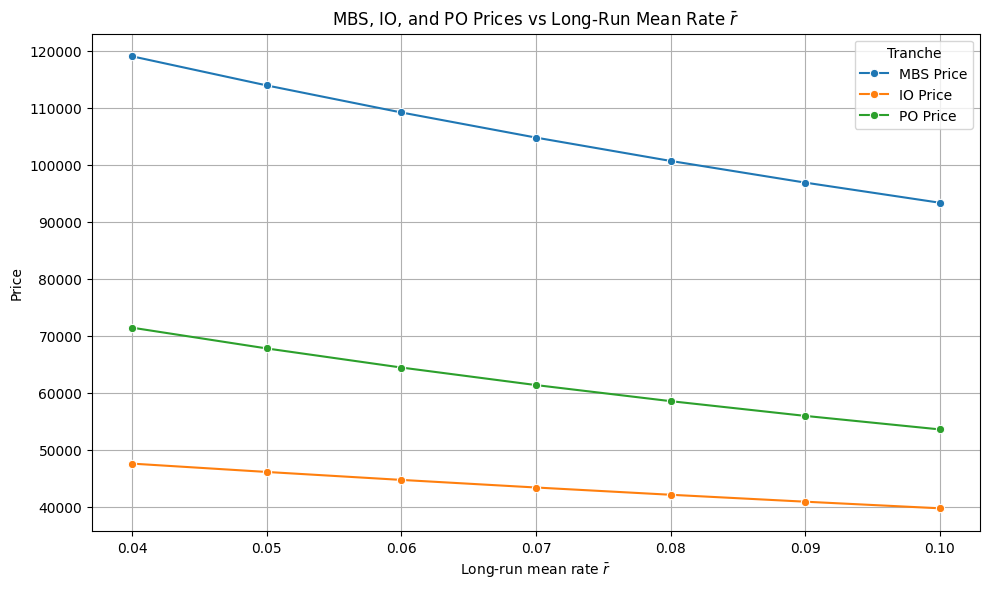

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt DataFrame for seaborn compatibility
df_melted = df_rbar.melt(id_vars="r_bar", var_name="Tranche", value_name="Price")

# Create plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x="r_bar", y="Price", hue="Tranche", marker="o")
plt.title("MBS, IO, and PO Prices vs Long-Run Mean Rate $\\bar{r}$")
plt.xlabel("Long-run mean rate $\\bar{r}$")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()
